<a href="https://colab.research.google.com/github/Serurays/Explainable_AI/blob/main/Explainable_AI_Brain_Tumor_Detection_MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip brain-tumor-mri-dataset

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [ ]:
# Set GPU device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
# Load data
TRAIN_ROOT = '/content/Training'
TEST_ROOT = '/content/Testing'

train_dataset = ImageFolder(root=TRAIN_ROOT,
                            transform=transforms.Compose([
                                transforms.Resize((255, 255)),
                                transforms.ToTensor()
                            ]))

test_dataset = ImageFolder(root=TEST_ROOT,
                           transform=transforms.Compose([
                               transforms.Resize((255, 255)),
                               transforms.ToTensor()
                           ]))

In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True)

        # Replace output layer
        in_feats = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Linear(in_feats, 4)

    def forward(self, x):
      x = self.vgg16(x)
      return x

model = CNNModel().to(device)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CNNModel(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16):

In [ ]:
batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [ ]:
# optimizer & loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [ ]:
def accuracy(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [ ]:
epochs = 10

for epoch in range(epochs):
  train_loss = 0
  train_acc = 0
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)

    # Calculate the loss & accuracy
    loss = loss_fn(outputs, labels)
    train_loss += loss.item()
    acc = accuracy(labels, torch.argmax(outputs, dim=1))
    train_acc += acc

    # Optimizer zero_grad
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Optimizer step
    optimizer.step()

  train_loss /= len(train_loader)
  train_acc /= len(train_loader)
  print(f'Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')

Epoch 1 | Train Loss: 0.5214 | Train Acc: 80.64%
Epoch 2 | Train Loss: 0.1789 | Train Acc: 93.42%
Epoch 3 | Train Loss: 0.0902 | Train Acc: 96.74%
Epoch 4 | Train Loss: 0.0469 | Train Acc: 98.41%
Epoch 5 | Train Loss: 0.0285 | Train Acc: 99.20%
Epoch 6 | Train Loss: 0.0152 | Train Acc: 99.63%
Epoch 7 | Train Loss: 0.0128 | Train Acc: 99.58%
Epoch 8 | Train Loss: 0.0046 | Train Acc: 99.91%
Epoch 9 | Train Loss: 0.0072 | Train Acc: 99.79%
Epoch 10 | Train Loss: 0.0170 | Train Acc: 99.48%


In [ ]:
# Inspect predictions for first batch
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.numpy()
outputs = model(inputs).argmax(1).detach().cpu().numpy()
comparison = pd.DataFrame()
print(f'Batch accuracy: {accuracy(torch.from_numpy(labels), torch.from_numpy(outputs)):.2f}%')
comparison['labels'] = labels
comparison['outputs'] = outputs
comparison

Batch accuracy: 96.88%


,labels,outputs
0,0,0
1,0,0
2,2,2
3,3,3
4,1,1
5,2,2
6,1,1
7,2,2
8,1,1
9,3,3


# Layerwise relevance propagation for VGG16
# For other CNN architectures this code might become more complex
# Source: https://git.tu-berlin.de/gmontavon/lrp-tutorial
# http://iphome.hhi.de/samek/pdf/MonXAI19.pdf

In [32]:
def new_layer(layer, g):
    """Clone a layer and pass its parameters through the function g."""
    layer = copy.deepcopy(layer)
    try: layer.weight = torch.nn.Parameter(g(layer.weight))
    except AttributeError: pass
    try: layer.bias = torch.nn.Parameter(g(layer.bias))
    except AttributeError: pass
    return layer

In [33]:
def dense_to_conv(layers):
    """ Converts a dense layer to a conv layer """
    newlayers = []
    for i,layer in enumerate(layers):
        if isinstance(layer, nn.Linear):
            newlayer = None
            if i == 0:
                m, n = 512, layer.weight.shape[0]
                newlayer = nn.Conv2d(m,n,7)
                newlayer.weight = nn.Parameter(layer.weight.reshape(n,m,7,7))
            else:
                m,n = layer.weight.shape[1],layer.weight.shape[0]
                newlayer = nn.Conv2d(m,n,1)
                newlayer.weight = nn.Parameter(layer.weight.reshape(n,m,1,1))
            newlayer.bias = nn.Parameter(layer.bias)
            newlayers += [newlayer]
        else:
            newlayers += [layer]
    return newlayers

In [34]:
def get_linear_layer_indices(model):
    offset = len(model.vgg16._modules['features']) + 1
    indices = []
    for i, layer in enumerate(model.vgg16._modules['classifier']):
        if isinstance(layer, nn.Linear):
            indices.append(i)
    indices = [offset + val for val in indices]
    return indices

In [35]:
def apply_lrp_on_vgg16(model, image):
    image = torch.unsqueeze(image, 0)
    # >>> Step 1: Extract layers
    layers = list(model.vgg16._modules['features']) \
                + [model.vgg16._modules['avgpool']] \
                + dense_to_conv(list(model.vgg16._modules['classifier']))
    linear_layer_indices = get_linear_layer_indices(model)
    # >>> Step 2: Propagate image through layers and store activations
    n_layers = len(layers)
    activations = [image] + [None] * n_layers # list of activations

    for layer in range(n_layers):
        if layer in linear_layer_indices:
            if layer == 32:
                activations[layer] = activations[layer].reshape((1, 512, 7, 7))
        activation = layers[layer].forward(activations[layer])
        if isinstance(layers[layer], torch.nn.modules.pooling.AdaptiveAvgPool2d):
            activation = torch.flatten(activation, start_dim=1)
        activations[layer+1] = activation

    # >>> Step 3: Replace last layer with one-hot-encoding
    output_activation = activations[-1].detach().cpu().numpy()
    max_activation = output_activation.max()
    one_hot_output = [val if val == max_activation else 0
                        for val in output_activation[0]]

    activations[-1] = torch.FloatTensor([one_hot_output]).to(device)

    # >>> Step 4: Backpropagate relevance scores
    relevances = [None] * n_layers + [activations[-1]]
    # Iterate over the layers in reverse order
    for layer in range(0, n_layers)[::-1]:
        current = layers[layer]
        # Treat max pooling layers as avg pooling
        if isinstance(current, torch.nn.MaxPool2d):
            layers[layer] = torch.nn.AvgPool2d(2)
            current = layers[layer]
        if isinstance(current, torch.nn.Conv2d) or \
           isinstance(current, torch.nn.AvgPool2d) or\
           isinstance(current, torch.nn.Linear):
            activations[layer] = activations[layer].data.requires_grad_(True)

            # Apply variants of LRP depending on the depth
            # see: https://link.springer.com/chapter/10.1007%2F978-3-030-28954-6_10
            # Lower layers, LRP-gamma >> Favor positive contributions (activations)
            if layer <= 16:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9
            # Middle layers, LRP-epsilon >> Remove some noise / Only most salient factors survive
            if 17 <= layer <= 30: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
            # Upper Layers, LRP-0 >> Basic rule
            if layer >= 31:       rho = lambda p: p;                       incr = lambda z: z+1e-9

            # Transform weights of layer and execute forward pass
            z = incr(new_layer(layers[layer],rho).forward(activations[layer]))
            # Element-wise division between relevance of the next layer and z
            s = (relevances[layer+1]/z).data
            # Calculate the gradient and multiply it by the activation
            (z * s).sum().backward();
            c = activations[layer].grad
            # Assign new relevance values
            relevances[layer] = (activations[layer]*c).data
        else:
            relevances[layer] = relevances[layer+1]

    # >>> Potential Step 5: Apply different propagation rule for pixels
    return relevances[0]

In [54]:
# Calculate relevances for first image in this test batch
image_id = 17
image_relevances = apply_lrp_on_vgg16(model, inputs[image_id])
image_relevances = image_relevances.permute(0,2,3,1).detach().cpu().numpy()[0]
image_relevances = np.interp(image_relevances, (image_relevances.min(),
                                                image_relevances.max()),
                                                (0, 1))

<ipython-input-35-8f9b6c5d9049>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  activations[-1] = torch.FloatTensor([one_hot_output]).to(device)


<ipython-input-55-a972272f0c65>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


Groundtruth for this image:  meningioma


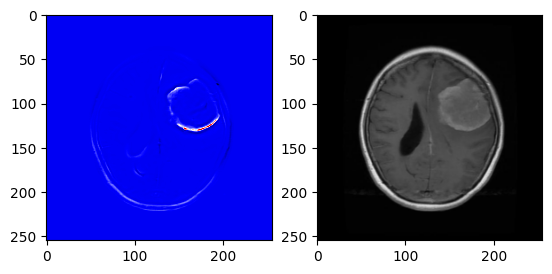

In [55]:
pred_label = list(test_dataset.class_to_idx.keys())[
             list(test_dataset.class_to_idx.values())
            .index(labels[image_id])]
if outputs[image_id] == labels[image_id]:
    print("Groundtruth for this image: ", pred_label)

    # Plot images next to each other
    plt.axis('off')
    plt.subplot(1,2,1)
    plt.imshow(image_relevances[:,:,0], cmap="seismic")
    plt.subplot(1,2,2)
    plt.imshow(inputs[image_id].permute(1,2,0).detach().cpu().numpy())
    plt.show()
else:
    print("This image is not classified correctly.")

https://youtu.be/PDRewtcqmaI?si=aJJR4N45Yn3RVl1l